# Setup & folders

In [1]:
# Cell 0 — setup
import os, pathlib, sys

BASE = pathlib.Path().resolve()
for d in ["data", "models", "plots", "it_risk_dashboard"]:
    (BASE/d).mkdir(exist_ok=True)

print("Working dir:", BASE)
print("Subdirs:", [p.name for p in BASE.iterdir() if p.is_dir()])

# Install libs (safe to re-run)
try:
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
    import joblib, requests
    from sklearn import __version__ as sklver
except Exception:
    %pip install -q pandas numpy matplotlib seaborn scikit-learn joblib requests python-dotenv streamlit
    import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
    import joblib, requests

%matplotlib inline


Working dir: C:\Users\mis
Subdirs: ['.anaconda', '.cache', '.chocolatey', '.codex', '.conda', '.continuum', '.cursor', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.streamlit', '.vscode', '3D Objects', 'anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'data', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'IntelGraphicsProfiles', 'it_risk_dashboard', 'Links', 'Local Settings', 'models', 'Music', 'My Documents', 'NetHood', 'notebooks', 'OneDrive', 'Pictures', 'plots', 'PrintHood', 'Recent', 'Risk_Management', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'Videos']


# Load your dataset

In [2]:
# Cell 1 — load data
import pandas as pd
from sklearn.model_selection import train_test_split

# Prefer your explicit train/test if present
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"
FULL_PATH  = "it_project_risk_dataset.csv"   # put your uploaded file here if different

def read_df(p):
    if os.path.exists(p):
        print("Loaded:", p)
        return pd.read_csv(p)
    return None

train = read_df(TRAIN_PATH)
test  = read_df(TEST_PATH)

if train is None or test is None:
    # Fall back to the combined dataset and split
    df = read_df(FULL_PATH)
    assert df is not None, "Upload it_project_risk_dataset.csv OR provide train.csv/test.csv"
    # Auto-detect/compose the binary target 'risk'
    if "risk" not in df.columns:
        if "risk_level" in df.columns:
            # Map: High -> 1, else 0  (keeps things simple & matches earlier metrics)
            df["risk"] = (df["risk_level"].str.strip().str.lower() == "high").astype(int)
        else:
            raise ValueError("No 'risk' or 'risk_level' found. Add a binary target or share column name.")
    # Keep a readable copy
    cols_to_drop = ["project_id"] if "project_id" in df.columns else []
    df_model = df.drop(columns=cols_to_drop)

    train, test = train_test_split(
        df_model, test_size=0.2, random_state=42, stratify=df_model["risk"]
    )
    train.to_csv("train.csv", index=False)
    test.to_csv("test.csv", index=False)
    print("Split saved -> train.csv & test.csv")

print("Train shape:", train.shape, " Test shape:", test.shape)
display(train.head(3))


Loaded: train.csv
Loaded: test.csv
Train shape: (800, 30)  Test shape: (200, 30)


,project_id,domain,methodology,team_location,vendor_contract_type,planned_budget_lakhs,planned_duration_days,team_size,team_experience_years_avg,tech_complexity,...,dependency_count,overdue_tasks_pct,requirements_clarity,risk_register_count,past_similar_success_rate,buffer_days,schedule_slippage_pct,cost_variance_pct,risk,risk_level
0,P1270,E-commerce,Hybrid,Co-located,T&M,47.71,204,20,3.59,2,...,13,0.113,5,3,0.736,8,0.00,-1.68,0,Low
1,P1571,Retail,Waterfall,Distributed,Fixed Bid,7.40,482,16,3.43,3,...,12,0.224,3,2,0.530,7,24.07,25.74,1,High
2,P1733,Telecom,Agile,Co-located,Managed Services,20.23,139,16,3.24,4,...,12,0.036,3,5,0.489,4,18.16,17.50,1,Medium


# EDA (quick, report-friendly)

Nulls:
 project_id                   0
domain                       0
methodology                  0
team_location                0
vendor_contract_type         0
planned_budget_lakhs         0
planned_duration_days        0
team_size                    0
team_experience_years_avg    0
tech_complexity              0
requirements_changes         0
open_bugs_count              0
vendor_dependency            0
stakeholder_count            0
offshore_ratio               0
sprint_length_days           0
story_points_planned         0
completed_rate               0
issue_churn_rate             0
reopens_rate                 0
dependency_count             0
overdue_tasks_pct            0
requirements_clarity         0
risk_register_count          0
past_similar_success_rate    0
buffer_days                  0
schedule_slippage_pct        0
cost_variance_pct            0
risk                         0
risk_level                   0
dtype: int64


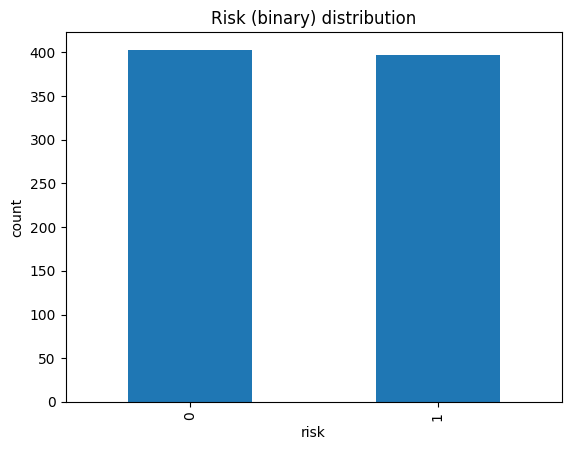

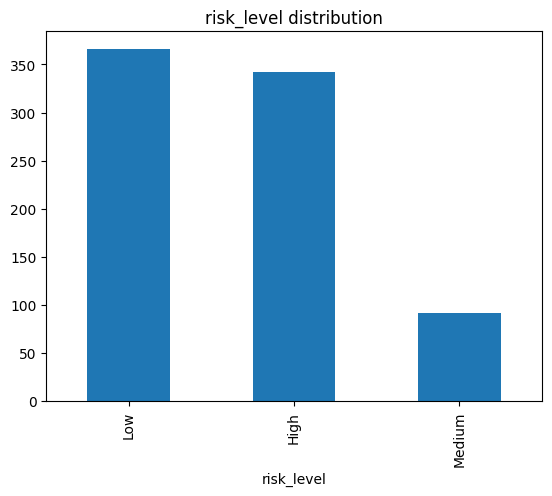

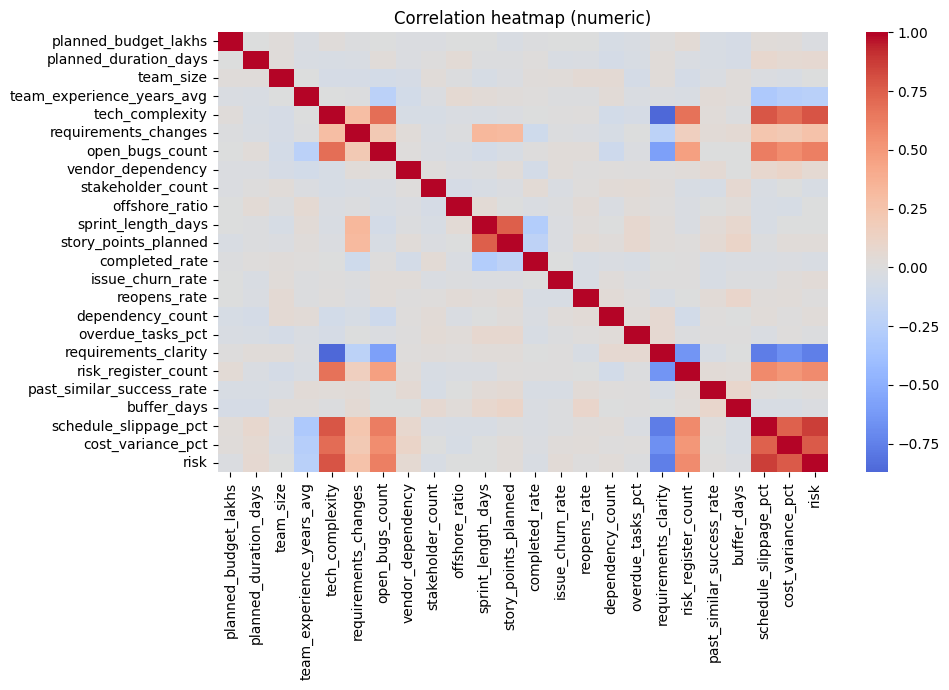

In [3]:
# Cell 2 — EDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Nulls:\n", train.isnull().sum())

# Risk distribution
plt.figure()
train["risk"].value_counts().plot(kind="bar")
plt.title("Risk (binary) distribution"); plt.xlabel("risk"); plt.ylabel("count")
plt.savefig("plots/risk_distribution.png", dpi=160)
plt.show()

# If you have 'risk_level', plot it too
if "risk_level" in train.columns:
    plt.figure()
    train["risk_level"].value_counts().plot(kind="bar")
    plt.title("risk_level distribution")
    plt.savefig("plots/risk_level_distribution.png", dpi=160)
    plt.show()

# Numeric correlation heatmap
num_cols = train.select_dtypes(include=[np.number]).columns
corr = train[num_cols].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric)")
plt.tight_layout(); plt.savefig("plots/corr_heatmap.png", dpi=160)
plt.show()


# Preprocessing pipeline

In [4]:
# Cell 3 — preprocessing pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

TARGET = "risk"
DROP = []
for col in ["project_id", "risk_level"]:  # safe to drop if present
    if col in train.columns:
        DROP.append(col)

X_train = train.drop(columns=[TARGET]+DROP)
y_train = train[TARGET].copy()

cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

print("Categorical:", cat_cols)
print("Numerical  :", num_cols)
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("Saved models/preprocessor.pkl")


Categorical: ['domain', 'methodology', 'team_location', 'vendor_contract_type']
Numerical  : ['planned_budget_lakhs', 'planned_duration_days', 'team_size', 'team_experience_years_avg', 'tech_complexity', 'requirements_changes', 'open_bugs_count', 'vendor_dependency', 'stakeholder_count', 'offshore_ratio', 'sprint_length_days', 'story_points_planned', 'completed_rate', 'issue_churn_rate', 'reopens_rate', 'dependency_count', 'overdue_tasks_pct', 'requirements_clarity', 'risk_register_count', 'past_similar_success_rate', 'buffer_days', 'schedule_slippage_pct', 'cost_variance_pct']
Saved models/preprocessor.pkl


# Train & evaluate top-3 models; plots


=== LogisticRegression ===
                model  accuracy  precision   recall        f1   roc_auc  \
0  LogisticRegression     0.945   0.969388  0.92233  0.945274  0.992293   

     pr_auc  
0  0.993024  

Confusion Matrix:
 [[94  3]
 [ 8 95]]

Classification Report:
               precision    recall  f1-score   support

           0      0.922     0.969     0.945        97
           1      0.969     0.922     0.945       103

    accuracy                          0.945       200
   macro avg      0.945     0.946     0.945       200
weighted avg      0.946     0.945     0.945       200


=== RandomForest ===
          model  accuracy  precision    recall        f1   roc_auc    pr_auc
0  RandomForest      0.94   0.950495  0.932039  0.941176  0.989891  0.990793

Confusion Matrix:
 [[92  5]
 [ 7 96]]

Classification Report:
               precision    recall  f1-score   support

           0      0.929     0.948     0.939        97
           1      0.950     0.932     0.941       103

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
0,LogisticRegression,0.945,0.969388,0.922330,0.945274,0.992293,0.993024
2,GradientBoosting,0.940,0.950495,0.932039,0.941176,0.991092,0.991577
1,RandomForest,0.940,0.950495,0.932039,0.941176,0.989891,0.990793


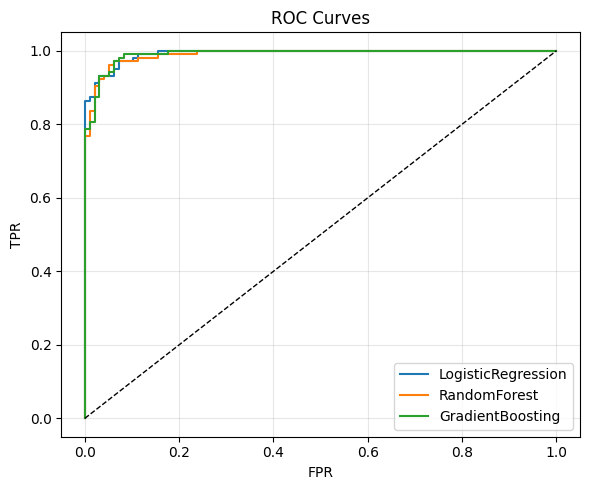

<Figure size 600x500 with 0 Axes>

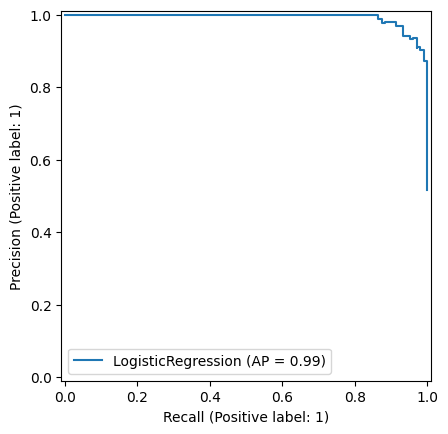

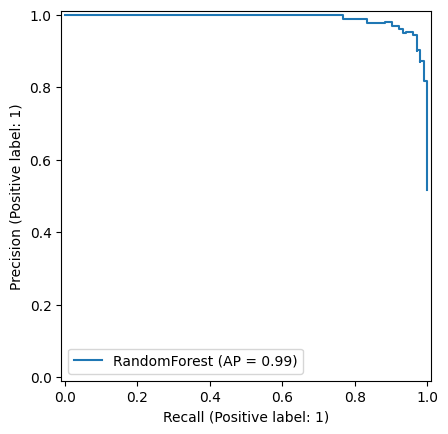

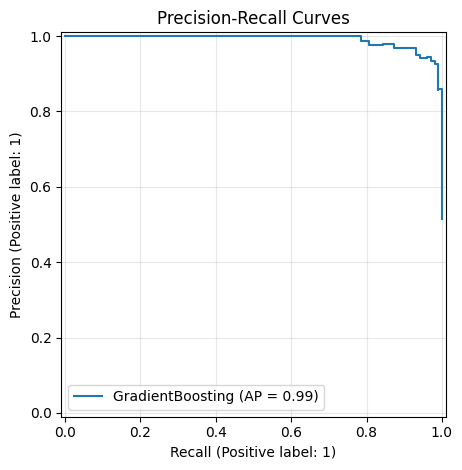

Saved plots + models/metrics.json


In [5]:
# Cell 4 — train + evaluate
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, average_precision_score,
                             confusion_matrix, classification_report, PrecisionRecallDisplay)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

X_test  = test.drop(columns=[TARGET]+[c for c in DROP if c in test.columns])
y_test  = test[TARGET].copy()

models = {
    "LogisticRegression": LogisticRegression(max_iter=300, solver="lbfgs"),
    "RandomForest": RandomForestClassifier(
        n_estimators=400, min_samples_split=4, class_weight="balanced_subsample", random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    ),
}

results, fitted = [], {}
for name, mdl in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", mdl)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob),
    }
    results.append(metrics)
    fitted[name] = {"pipe": pipe, "y_pred": y_pred, "y_prob": y_prob}
    print(f"\n=== {name} ===")
    print(pd.DataFrame(metrics, index=[0]))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

results_df = pd.DataFrame(results).sort_values(by=["f1","roc_auc"], ascending=False)
display(results_df)

# ROC curves
plt.figure(figsize=(6,5))
for name, obj in fitted.items():
    fpr, tpr, _ = roc_curve(y_test, obj["y_prob"])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("plots/roc_curves.png", dpi=160); plt.show()

# PR curves
plt.figure(figsize=(6,5))
for name, obj in fitted.items():
    PrecisionRecallDisplay.from_predictions(y_test, obj["y_prob"], name=name)
plt.title("Precision-Recall Curves"); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig("plots/pr_curves.png", dpi=160); plt.show()

with open("models/metrics.json","w") as f:
    json.dump(results_df.to_dict(orient="records"), f, indent=2)
print("Saved plots + models/metrics.json")


# Save the best model for Streamlit/Jira

In [6]:
# Cell 5 — save best model
best_name = results_df.iloc[0]["model"]
best_pipe = fitted[best_name]["pipe"]

os.makedirs("models", exist_ok=True)
MODEL_PATH = f"models/best_model__{best_name}.pkl"
joblib.dump(best_pipe, MODEL_PATH)
print("Best model:", best_name)
print("Saved:", MODEL_PATH)


Best model: LogisticRegression
Saved: models/best_model__LogisticRegression.pkl


# Connect to Jira & fetch issues (uses .env)

In [7]:
# Cell 6 — Jira auth + fetch issues
from dotenv import load_dotenv
import os, requests, pandas as pd

# If your .env is elsewhere, pass full path here:
load_dotenv(r"C:\Users\mis\Risk_Management\.env")
#load_dotenv()  # if .env is next to the notebook

JIRA_EMAIL = os.getenv("JIRA_EMAIL")
JIRA_TOKEN = os.getenv("JIRA_API_TOKEN")
JIRA_SITE  = os.getenv("JIRA_SITE")
PROJECT_KEY = os.getenv("JIRA_PROJECT_KEY")

if JIRA_SITE and not JIRA_SITE.startswith("http"):
    JIRA_SITE = "https://" + JIRA_SITE

# Auth test
r = requests.get(f"{JIRA_SITE}/rest/api/3/myself", auth=(JIRA_EMAIL, JIRA_TOKEN), timeout=30)
print("Auth status:", r.status_code)
assert r.status_code == 200, f"Auth failed: {r.text[:200]}"

def fetch_jira_issues(site_url, email, token, jql, max_results=50):
    url = f"{site_url}/rest/api/3/search"
    params = {
        "jql": jql,
        "maxResults": max_results,
        "fields": "summary,issuetype,status,labels,duedate,created,updated,assignee"
    }
    resp = requests.get(url, params=params, auth=(email, token), timeout=30)
    resp.raise_for_status()
    return resp.json().get("issues", [])

JQL = f"project={PROJECT_KEY} ORDER BY updated DESC"
issues = fetch_jira_issues(JIRA_SITE, JIRA_EMAIL, JIRA_TOKEN, JQL, max_results=20)
print("Fetched issues:", len(issues))

rows = []
for it in issues:
    f = it.get("fields", {})
    rows.append({
        "key": it.get("key"),
        "summary": f.get("summary"),
        "issue_type": (f.get("issuetype") or {}).get("name"),
        "status": (f.get("status") or {}).get("name"),
        "labels": f.get("labels", []),
        "due_date": f.get("duedate"),
        "created": f.get("created"),
        "updated": f.get("updated"),
        "assignee": (f.get("assignee") or {}).get("displayName"),
    })
df_issues = pd.DataFrame(rows)
display(df_issues.head(10))


Auth status: 200
Fetched issues: 6


,key,summary,issue_type,status,labels,due_date,created,updated,assignee
0,MBA-1,(Sample) Transaction Management,Epic,In Progress,[ml_risk_low],2025-10-03,2025-09-19T15:59:14.851+0530,2025-09-20T15:48:42.173+0530,None
1,MBA-3,(Sample) Initiate Fund Transfer,Story,To Do,[ml_risk_low],None,2025-09-19T15:59:15.698+0530,2025-09-20T15:48:41.371+0530,None
2,MBA-4,(Sample) Two-Factor Authentication Setup,Story,In Progress,[ml_risk_low],None,2025-09-19T15:59:15.699+0530,2025-09-20T15:48:40.673+0530,None
3,MBA-5,(Sample) View Transaction History,Task,In Progress,[ml_risk_low],None,2025-09-19T15:59:15.702+0530,2025-09-20T15:48:39.945+0530,None
4,MBA-6,(Sample) Implement Biometric Login,Task,In Review,[ml_risk_low],None,2025-09-19T15:59:15.704+0530,2025-09-20T15:48:39.212+0530,None
5,MBA-2,(Sample) User Authentication,Epic,In Progress,[],2025-09-26,2025-09-19T15:59:14.851+0530,2025-09-19T15:59:15.404+0530,None


# Derive Jira → model features (prototype)

In [8]:
# Cell 7 — derive a SINGLE feature row from issues
import datetime as dt
import pandas as pd

def derive_features_from_issues(issues):
    now = dt.datetime.utcnow().date()
    done = {"Done","Closed","Resolved"}
    total = len(issues)
    bug_open, overdue = 0, 0
    for it in issues:
        f = it.get("fields", {})
        itype = (f.get("issuetype") or {}).get("name","").lower()
        status = (f.get("status") or {}).get("name","")
        duedate = f.get("duedate")
        if "bug" in itype and status not in done:
            bug_open += 1
        if duedate and status not in done:
            try:
                if dt.datetime.strptime(duedate, "%Y-%m-%d").date() < now:
                    overdue += 1
            except Exception:
                pass
    overdue_pct = (overdue / total) if total else 0.0

    return pd.DataFrame([{
        "domain": "Telecom",
        "methodology": "Agile",
        "team_location": "Hybrid",
        "vendor_contract_type": "T&M",
        "planned_budget_lakhs": 50.0,
        "planned_duration_days": 180,
        "team_size": 12,
        "team_experience_years_avg": 5.0,
        "tech_complexity": 3,
        "requirements_changes": max(10, total//5),
        "open_bugs_count": bug_open,
        "vendor_dependency": 0,
        "stakeholder_count": 8,
        "offshore_ratio": 0.30,
        "sprint_length_days": 14,
        "story_points_planned": 200,
        "completed_rate": 0.90,
        "issue_churn_rate": 0.12,
        "reopens_rate": 0.05,
        "dependency_count": 5,
        "overdue_tasks_pct": round(overdue_pct, 3),
        "requirements_clarity": 3,
        "risk_register_count": 6,
        "past_similar_success_rate": 0.70,
        "buffer_days": 10,
        "schedule_slippage_pct": overdue_pct * 30,
        "cost_variance_pct": overdue_pct * 20,
    }])

features_df = derive_features_from_issues(issues)
display(features_df)


C:\Users\mis\AppData\Local\Temp\ipykernel_21748\3672822232.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = dt.datetime.utcnow().date()


,domain,methodology,team_location,vendor_contract_type,planned_budget_lakhs,planned_duration_days,team_size,team_experience_years_avg,tech_complexity,requirements_changes,...,issue_churn_rate,reopens_rate,dependency_count,overdue_tasks_pct,requirements_clarity,risk_register_count,past_similar_success_rate,buffer_days,schedule_slippage_pct,cost_variance_pct
0,Telecom,Agile,Hybrid,T&M,50.0,180,12,5.0,3,10,...,0.12,0.05,5,0.0,3,6,0.7,10,0.0,0.0


# Predict risk from Jira features; save output

In [14]:
# # Cell 8 — predict Jira project risk
# import numpy as np, joblib

# # Use best model saved in Cell 5
# MODEL_PATH = [p for p in os.listdir("models") if p.startswith("best_model__") and p.endswith(".pkl")]
# assert MODEL_PATH, "Best model not found in models/. Run Cell 5."
# MODEL_PATH = "models/" + MODEL_PATH[0]
# pipe = joblib.load(MODEL_PATH)

# proba = pipe.predict_proba(features_df)[:, 1]
# pred  = (proba >= 0.50).astype(int)
# risk_level = np.where(proba >= 0.67, "High",
#                np.where(proba >= 0.40, "Medium", "Low"))

# out = features_df.copy()
# out["risk_probability"] = np.round(proba, 4)
# out["risk_predicted"]   = pred
# out["risk_level_predicted"] = risk_level
# display(out)

# out.to_csv("jira_prediction_output.csv", index=False)
# print("Saved jira_prediction_output.csv")
import pandas as pd, joblib, numpy as np

# Load test data
test = pd.read_csv("test.csv")

# Load model
MODEL_PATH = "models/best_model__LogisticRegression.pkl"  # adjust if different
pipe = joblib.load(MODEL_PATH)

# Features (drop target + IDs if present)
X_test = test.drop(columns=["risk","risk_level","project_id"], errors="ignore")

# Predict
proba = pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)
risk_level = np.where(proba >= 0.67,"High",np.where(proba >= 0.40,"Medium","Low"))

test_out = test.copy()
test_out["risk_probability"] = np.round(proba,4)
test_out["risk_predicted"] = pred
test_out["risk_level_predicted"] = risk_level

# Save
test_out.to_csv("test_predictions.csv", index=False)
display(test_out.head())


,project_id,domain,methodology,team_location,vendor_contract_type,planned_budget_lakhs,planned_duration_days,team_size,team_experience_years_avg,tech_complexity,...,risk_register_count,past_similar_success_rate,buffer_days,schedule_slippage_pct,cost_variance_pct,risk,risk_level,risk_probability,risk_predicted,risk_level_predicted
0,P1798,E-commerce,Waterfall,Distributed,Fixed Bid,23.20,122,10,6.75,4,...,5,0.110,13,32.50,22.50,1,High,1.0000,1,High
1,P1007,E-commerce,Hybrid,Co-located,T&M,29.04,190,18,4.18,4,...,8,0.479,5,21.20,28.49,1,High,1.0000,1,High
2,P1386,Fintech,Agile,Distributed,Fixed Bid,26.40,163,13,4.09,2,...,5,0.411,0,0.00,-0.58,0,Low,0.0001,0,Low
3,P1666,Government,Agile,Hybrid,Fixed Bid,33.08,93,13,7.16,2,...,0,0.631,13,0.00,15.31,0,Low,0.0000,0,Low
4,P1913,Fintech,Agile,Co-located,Fixed Bid,13.77,294,13,4.05,5,...,4,0.736,0,26.12,22.77,1,High,1.0000,1,High


# Push result back to Jira via Labels

In [15]:
import requests

def add_label(issue_key: str, label_text: str):
    url = f"{JIRA_SITE}/rest/api/3/issue/{issue_key}"
    payload = {"update": {"labels": [{"add": label_text}]}}
    r = requests.put(
        url,
        auth=(JIRA_EMAIL, JIRA_TOKEN),
        headers={"Content-Type": "application/json"},
        json=payload,
        timeout=30
    )
    return r.status_code, r.text[:200]

# Example: push first 5 test predictions into Jira
for i, row in test_out.head(5).iterrows():
    issue_key = "RISK-" + str(100+i)   # ⚠️ Replace with real Jira issue keys
    risk_label = f"ml_risk_{row['risk_level_predicted'].lower()}"
    code, msg = add_label(issue_key, risk_label)
    print(issue_key, risk_label, code)


RISK-100 ml_risk_high 404
RISK-101 ml_risk_high 404
RISK-102 ml_risk_low 404
RISK-103 ml_risk_low 404
RISK-104 ml_risk_high 404


# Create Streamlit app files

In [11]:
# Cell 10 — write a ready-to-run Streamlit app to ./it_risk_dashboard
from pathlib import Path
import pandas as pd, textwrap, os

APP = Path("it_risk_dashboard"); APP.mkdir(exist_ok=True)

# sample_input_template.csv from training columns
train = pd.read_csv("train.csv")
tpl_cols = [c for c in train.columns if c not in ["project_id","risk","risk_level"]]
train[tpl_cols].head(5).to_csv(APP/"sample_input_template.csv", index=False)

(Path(APP/"predict_helper.py")).write_text(textwrap.dedent("""
import joblib, numpy as np, pandas as pd
def load_model(path_or_bytes): return joblib.load(path_or_bytes)
def predict_df(pipe, df_in: pd.DataFrame) -> pd.DataFrame:
    proba = pipe.predict_proba(df_in)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    out = df_in.copy()
    out["risk_probability"] = np.round(proba, 4)
    out["risk_predicted"] = pred
    out["risk_level_predicted"] = np.where(out["risk_probability"] >= 0.67, "High",
                                   np.where(out["risk_probability"] >= 0.40, "Medium", "Low"))
    return out
"""))

(Path(APP/"app.py")).write_text(textwrap.dedent("""
import os, io, pandas as pd, streamlit as st
from predict_helper import load_model, predict_df

st.set_page_config(page_title="IT Project Risk Dashboard", layout="wide")
st.title("🔎 IT Project Risk Dashboard")
st.caption("Upload model .pkl, then predict risk from form or CSV")

with st.sidebar:
    st.header("Model")
    model = None
    src = st.selectbox("Load model from", ["Upload .pkl", "Path"])
    if src=="Upload .pkl":
        up = st.file_uploader("Upload trained pipeline (.pkl)", type=["pkl"])
        if up:
            model = load_model(io.BytesIO(up.read()))
            st.success("Model loaded from upload.")
    else:
        p = st.text_input("Model path", value="models/best_model__LogisticRegression.pkl")
        if os.path.exists(p):
            model = load_model(p); st.success(f"Loaded: {p}")
        else:
            st.info("Enter a valid path or upload a .pkl.")

st.header("Predict")
mode = st.radio("Input mode", ["Manual form","Upload CSV"])

def run_predict(df):
    global model
    if model is None:
        st.error("Load model first.")
        return
    out = predict_df(model, df)
    st.dataframe(out, use_container_width=True)
    st.write("Counts:", out["risk_level_predicted"].value_counts())

if mode=="Manual form":
    c1,c2,c3 = st.columns(3)
    with c1:
        domain = st.selectbox("domain", ["Fintech","Retail","Healthcare","Telecom","Government","E-commerce"])
        methodology = st.selectbox("methodology", ["Agile","Waterfall","Hybrid"])
        team_location = st.selectbox("team_location", ["Co-located","Distributed","Hybrid"])
        vendor_contract_type = st.selectbox("vendor_contract_type", ["T&M","Fixed Bid","Managed Services"])
    with c2:
        planned_budget_lakhs = st.number_input("planned_budget_lakhs", 1.0, 5000.0, 50.0)
        planned_duration_days = st.number_input("planned_duration_days", 30, 1000, 180)
        team_size = st.number_input("team_size", 1, 200, 12)
        team_experience_years_avg = st.number_input("team_experience_years_avg", 0.0, 30.0, 5.0)
    with c3:
        tech_complexity = st.slider("tech_complexity (1-5)", 1, 5, 3)
        requirements_changes = st.number_input("requirements_changes", 0, 500, 12)
        open_bugs_count = st.number_input("open_bugs_count", 0, 500, 10)
        overdue_tasks_pct = st.number_input("overdue_tasks_pct (0..1)", 0.0, 1.0, 0.1)

    if st.button("Predict"):
        row = dict(domain=domain, methodology=methodology, team_location=team_location, vendor_contract_type=vendor_contract_type,
                   planned_budget_lakhs=planned_budget_lakhs, planned_duration_days=planned_duration_days,
                   team_size=team_size, team_experience_years_avg=team_experience_years_avg, tech_complexity=tech_complexity,
                   requirements_changes=requirements_changes, open_bugs_count=open_bugs_count, vendor_dependency=0,
                   stakeholder_count=8, offshore_ratio=0.3, sprint_length_days=14 if methodology=="Agile" else 0,
                   story_points_planned=200 if methodology=="Agile" else 0, completed_rate=0.9, issue_churn_rate=0.12,
                   reopens_rate=0.05, dependency_count=5, overdue_tasks_pct=overdue_tasks_pct, requirements_clarity=3,
                   risk_register_count=6, past_similar_success_rate=0.7, buffer_days=10, schedule_slippage_pct=overdue_tasks_pct*30,
                   cost_variance_pct=overdue_tasks_pct*20)
        df = pd.DataFrame([row])
        run_predict(df)

else:
    up = st.file_uploader("Upload CSV with training feature columns", type=["csv"])
    if up:
        df = pd.read_csv(up)
        st.write("Preview:", df.head())
        if st.button("Predict for uploaded CSV"):
            run_predict(df)
"""))

(Path(APP/"requirements.txt")).write_text("streamlit\npandas\nnumpy\njoblib\nscikit-learn\n")
print("✅ Streamlit app written to ./it_risk_dashboard")
print("Run:  streamlit run it_risk_dashboard/app.py")


✅ Streamlit app written to ./it_risk_dashboard
Run:  streamlit run it_risk_dashboard/app.py


In [16]:
!streamlit run it_risk_dashboard/app.py


^C
